## Import Libraries

In [32]:
import numpy as np;
import pandas as pd;
import seaborn as sns;
import matplotlib.pyplot as plt;
import category_encoders as ce;
from sklearn.linear_model import LogisticRegression;
from sklearn.model_selection import train_test_split;
from sklearn.preprocessing import RobustScaler;

In [22]:
LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = LOCAL

train = pd.merge(pd.read_csv(source + 'train_features.csv'), pd.read_csv(source + 'train_labels.csv'));
test = pd.read_csv(source + 'test_features.csv');
sample_submission = pd.read_csv(source + 'sample_submission.csv');

train, val = train_test_split(train, train_size=0.80, test_size=0.20, stratify=train['status_group'], random_state=42);

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [23]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,...,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [24]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [25]:
def wrangle(data):
    data_copy = data.copy();
    
    data_copy['latitude'] = data_copy['latitude'].replace(-2e-08, 0);
    
    cols_with_zeroes = ['construction_year', 'latitude', 'longitude'];
    for col in cols_with_zeroes:
        data_copy[col].replace(0, np.nan);
        data_copy[col].fillna(data_copy[col].mean());

    data_copy['date_recorded'] = pd.to_datetime(data_copy['date_recorded'], infer_datetime_format=True);
    
    data_copy['year_recorded'] = data_copy['date_recorded'].dt.year;
    
    data_copy = data_copy.drop(columns='quantity_group');
    
    categoricals = data_copy.select_dtypes(exclude='number').columns;
    for col in categoricals:
        data_copy[col] = data_copy[col].fillna('MISSING');
    return data_copy;

train = wrangle(train);
val = wrangle(val);
test = wrangle(test);

In [30]:
target = 'status_group';
train_features = train.drop(columns=[target, 'id']);

numeric_features = train_features.select_dtypes(include='number').columns.tolist();

cardinality = train_features.select_dtypes(exclude='number').nunique();

categorical_features = cardinality[cardinality <= 50].index.tolist();

features = numeric_features + categorical_features;

In [31]:
x_train = train[features];
y_train = train[target];
x_val = val[features];
y_val = val[target];

x_test = test[features];

encoder = ce.OneHotEncoder(use_cat_names=True);
x_train_encoded = encoder.fit_transform(x_train);
x_val_encoded = encoder.transform(x_val);
x_test_encoded = encoder.transform(x_test);

scalar = RobustScaler();
x_train_scaled = scalar.fit_transform(x_train_encoded);
x_val_scaled = scalar.transform(x_val_encoded);
x_test_scaled = scalar.transform(x_test_encoded);

model = LogisticRegression();
model.fit(x_train_scaled, y_train);
print('Validation Accuracy:', model.score(x_val_scaled, y_val));

y_pred = model.predict(x_test_scaled);

submission = sample_submission.copy();
submission['status_group'] = y_pred;
submission.to_csv('submission-02.csv', index=False);

/Users/ashwin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ashwin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Validation Accuracy: 0.7331649831649831


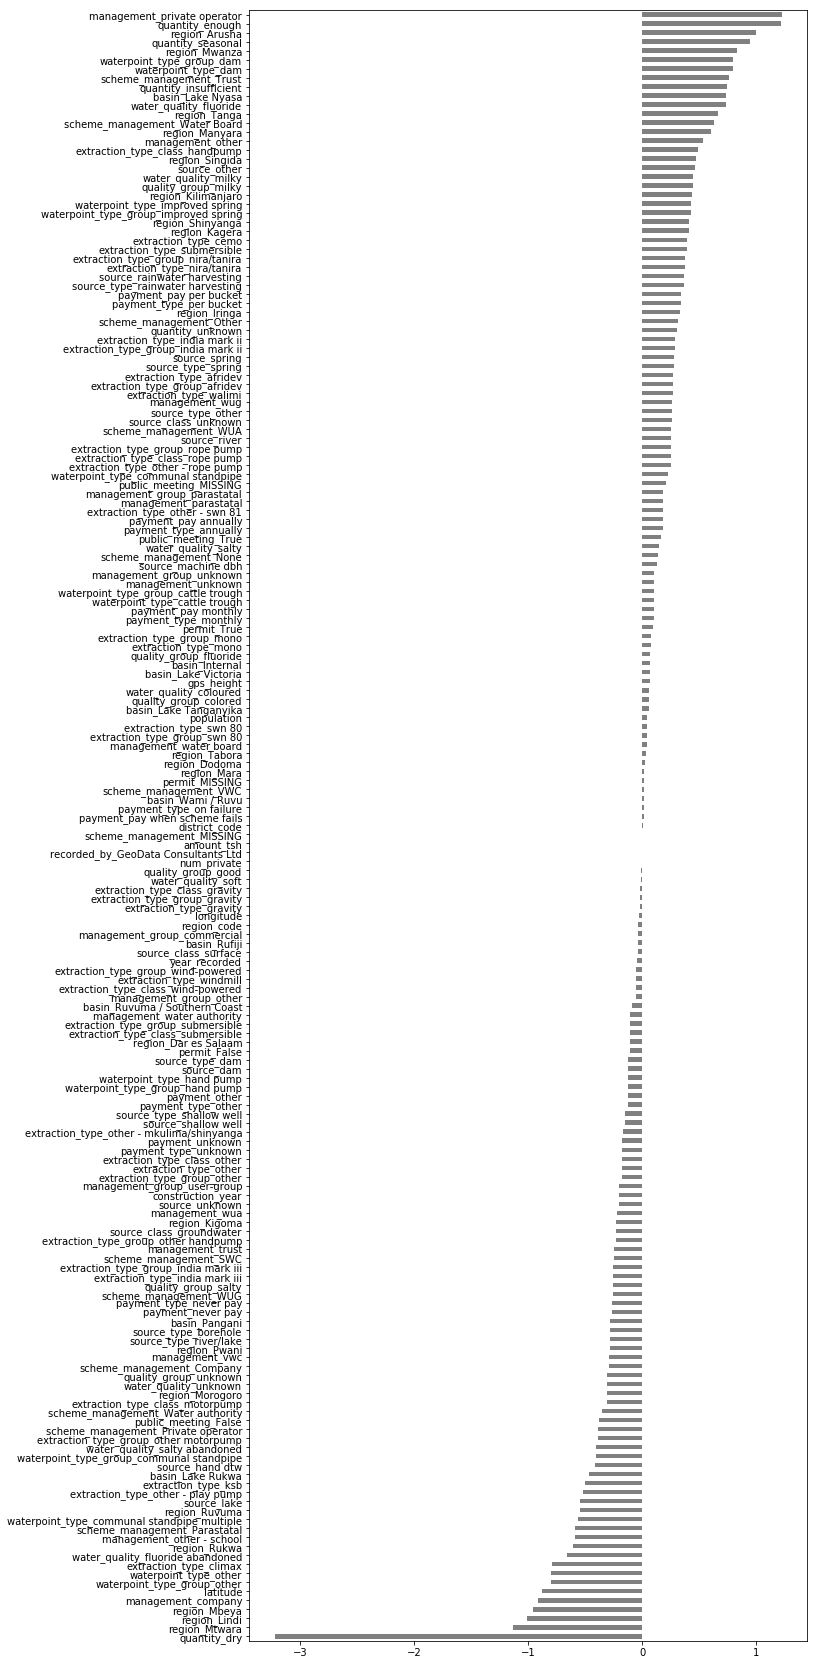

In [33]:
coefs = pd.Series(model.coef_[0], x_test_encoded.columns);
plt.figure(figsize=(10, 30));
coefs.sort_values().plot.barh(color='grey');

In [34]:
train_location = train[['longitude', 'latitude']].copy();
val_location = val[['longitude', 'latitude']].copy();
lr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1);
lr.fit(train_location, y_train);
print('Logistic Regression Mode;');
print('Train Acc:', lr.score(train_location, y_train));
print('Val Acc:', lr.score(val_location, y_val));

Logistic Regression Mode;
Train Acc: 0.5430765993265994
Val Acc: 0.5430976430976431


In [35]:
from sklearn.tree import DecisionTreeClassifier;

dt = DecisionTreeClassifier(random_state=42);
dt.fit(train_location, y_train);
print('Decision Tree');
print('Train Acc:', dt.score(train_location, y_train));
print('Val Acc:', dt.score(val_location, y_val));

Decision Tree
Train Acc: 0.984196127946128
Val Acc: 0.6267676767676768


In [38]:
max_dt_depth = 10;
dt2 = DecisionTreeClassifier(max_depth=max_dt_depth, random_state=42);
dt2.fit(train_location, y_train);
print('Decision Tree');
print(f'Decision Tree Model: Max Depth = {max_dt_depth}')
print(f'Train Acc: {dt2.score(train_location, y_train)}');
print(f'Val Acc: {dt2.score(val_location, y_val)}');

Decision Tree
Decision Tree Model: Max Depth = 10
Train Acc: 0.6575968013468013
Val Acc: 0.6303872053872054


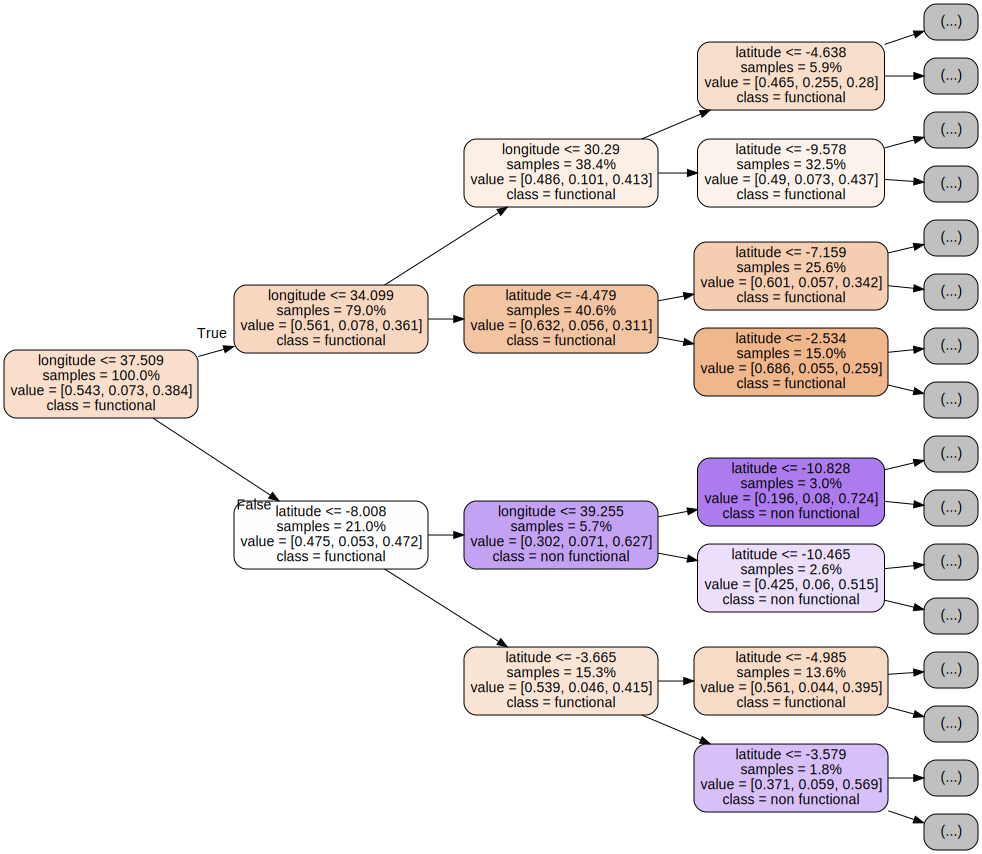

In [43]:
import graphviz;
from sklearn.tree import export_graphviz;

dot_data = export_graphviz(dt2, out_file=None, max_depth=3, feature_names=train_location.columns,
                          class_names=dt.classes_, impurity=False, filled=True, proportion=True,
                          rotate=True, rounded=True);

graphviz.Source(dot_data)